In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from etna.datasets import TSDataset
from etna.transforms import LagTransform
from etna.models import CatBoostMultiSegmentModel
from etna.pipeline import Pipeline
from etna.models import LinearPerSegmentModel
from etna.metrics import SMAPE, MAPE

In [22]:
data = pd.read_csv('../data/processed/msk_segment_days.csv', index_col=0)
data.head()

,timestamp,target,segment
0,2018-03-04,4704280,k=3_t=11_r=1
1,2018-03-17,8000000,k=4_t=1_r=2
2,2018-04-03,11500000,k=6_t=1_r=3
3,2018-04-07,10200000,k=8_t=1_r=2
4,2018-04-18,11500000,k=16_t=1_r=1


In [23]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [24]:
# Чтобы убрать совпадение и в 1 день не было 2-х значений
data = data.groupby(['timestamp', 'segment']).agg({'target' : ['mean']}).reset_index()
data.columns = ["timestamp", "segment", "target"]

In [25]:
list_segment = list(data.segment.unique())

In [26]:
data_etna = TSDataset.to_dataset(data)
data_etna.head(5)

segment,k=0_t=11_r=1,k=0_t=11_r=2,k=0_t=11_r=3,k=0_t=11_r=4,k=0_t=1_r=1,k=0_t=1_r=2,k=0_t=1_r=3,k=0_t=1_r=4,k=10_t=11_r=1,k=10_t=11_r=2,...,k=8_t=1_r=3,k=8_t=1_r=4,k=9_t=11_r=1,k=9_t=11_r=2,k=9_t=11_r=3,k=9_t=11_r=4,k=9_t=1_r=1,k=9_t=1_r=2,k=9_t=1_r=3,k=9_t=1_r=4
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
ts = TSDataset(data_etna, freq="D")

In [28]:
ts.head(10)

segment,k=0_t=11_r=1,k=0_t=11_r=2,k=0_t=11_r=3,k=0_t=11_r=4,k=0_t=1_r=1,k=0_t=1_r=2,k=0_t=1_r=3,k=0_t=1_r=4,k=10_t=11_r=1,k=10_t=11_r=2,...,k=8_t=1_r=3,k=8_t=1_r=4,k=9_t=11_r=1,k=9_t=11_r=2,k=9_t=11_r=3,k=9_t=11_r=4,k=9_t=1_r=1,k=9_t=1_r=2,k=9_t=1_r=3,k=9_t=1_r=4
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df = ts.to_pandas()

In [30]:
df.head()

segment,k=0_t=11_r=1,k=0_t=11_r=2,k=0_t=11_r=3,k=0_t=11_r=4,k=0_t=1_r=1,k=0_t=1_r=2,k=0_t=1_r=3,k=0_t=1_r=4,k=10_t=11_r=1,k=10_t=11_r=2,...,k=8_t=1_r=3,k=8_t=1_r=4,k=9_t=11_r=1,k=9_t=11_r=2,k=9_t=11_r=3,k=9_t=11_r=4,k=9_t=1_r=1,k=9_t=1_r=2,k=9_t=1_r=3,k=9_t=1_r=4
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df = df["2018-09-25":]

In [32]:
df

segment,k=0_t=11_r=1,k=0_t=11_r=2,k=0_t=11_r=3,k=0_t=11_r=4,k=0_t=1_r=1,k=0_t=1_r=2,k=0_t=1_r=3,k=0_t=1_r=4,k=10_t=11_r=1,k=10_t=11_r=2,...,k=8_t=1_r=3,k=8_t=1_r=4,k=9_t=11_r=1,k=9_t=11_r=2,k=9_t=11_r=3,k=9_t=11_r=4,k=9_t=1_r=1,k=9_t=1_r=2,k=9_t=1_r=3,k=9_t=1_r=4
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-09-25,NaN,9.515588e+06,1.144173e+07,15773360.0,6.250000e+06,9.032000e+06,10879800.0,1.150000e+07,7.350000e+06,NaN,...,1.078000e+07,15000000.0,8.606000e+06,8.924690e+06,1.628550e+07,25756500.0,9.128357e+06,1.175678e+07,2.290000e+07,29000000.0
2018-09-26,6.225320e+06,8.849250e+06,NaN,NaN,6.360000e+06,8.966667e+06,9698000.0,NaN,4.189500e+06,NaN,...,1.330800e+07,22500000.0,1.074000e+07,1.712807e+07,2.650000e+07,NaN,8.635714e+06,1.750111e+07,2.521000e+07,22200000.0
2018-09-27,6.655950e+06,7.474590e+06,1.163351e+07,NaN,5.825000e+06,9.237500e+06,10795000.0,NaN,8.798400e+06,NaN,...,1.207500e+07,17800000.0,1.111353e+07,1.572500e+07,2.601954e+07,NaN,7.353522e+06,1.122222e+07,1.953333e+07,NaN
2018-09-28,6.495771e+06,8.743473e+06,1.104971e+07,16876800.0,6.133167e+06,8.025000e+06,13150000.0,1.446667e+07,4.937013e+06,6.682571e+06,...,2.185000e+07,22850000.0,9.248379e+06,1.431469e+07,1.800974e+07,NaN,8.644000e+06,1.110729e+07,1.866000e+07,25900000.0
2018-09-29,6.220890e+06,9.030392e+06,1.195103e+07,NaN,5.275000e+06,8.385000e+06,9870000.0,NaN,NaN,NaN,...,1.336667e+07,NaN,1.057918e+07,NaN,2.006914e+07,NaN,9.650000e+06,1.029733e+07,1.705000e+07,38500000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-27,1.012222e+07,1.338514e+07,1.591422e+07,NaN,9.290150e+06,1.105536e+07,14800000.0,1.420000e+07,NaN,1.440431e+07,...,2.082500e+07,12345000.0,9.569749e+06,1.248110e+07,2.431945e+07,NaN,1.471500e+07,2.038333e+07,2.733349e+07,NaN
2021-04-28,NaN,NaN,NaN,NaN,1.118850e+07,NaN,14600000.0,NaN,NaN,NaN,...,1.800000e+07,21000000.0,NaN,1.676500e+07,NaN,NaN,1.350000e+07,2.507475e+07,2.223750e+07,33750000.0


In [33]:
df = df.interpolate('time')

In [34]:
df.head()

segment,k=0_t=11_r=1,k=0_t=11_r=2,k=0_t=11_r=3,k=0_t=11_r=4,k=0_t=1_r=1,k=0_t=1_r=2,k=0_t=1_r=3,k=0_t=1_r=4,k=10_t=11_r=1,k=10_t=11_r=2,...,k=8_t=1_r=3,k=8_t=1_r=4,k=9_t=11_r=1,k=9_t=11_r=2,k=9_t=11_r=3,k=9_t=11_r=4,k=9_t=1_r=1,k=9_t=1_r=2,k=9_t=1_r=3,k=9_t=1_r=4
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-09-25,NaN,9.515588e+06,1.144173e+07,1.577336e+07,6.250000e+06,9.032000e+06,10879800.0,1.150000e+07,7.350000e+06,NaN,...,1.078000e+07,15000000.0,8.606000e+06,8.924690e+06,16285500.0,2.575650e+07,9.128357e+06,1.175678e+07,2.290000e+07,29000000.0
2018-09-26,6225320.0,8.849250e+06,1.153762e+07,1.614117e+07,6.360000e+06,8.966667e+06,9698000.0,1.248889e+07,4.189500e+06,NaN,...,1.330800e+07,22500000.0,1.074000e+07,1.712807e+07,26500000.0,2.584123e+07,8.635714e+06,1.750111e+07,2.521000e+07,22200000.0
2018-09-27,6655949.5,7.474590e+06,1.163351e+07,1.650899e+07,5.825000e+06,9.237500e+06,10795000.0,1.347778e+07,8.798400e+06,NaN,...,1.207500e+07,17800000.0,1.111353e+07,1.572500e+07,26019535.0,2.592597e+07,7.353522e+06,1.122222e+07,1.953333e+07,24050000.0
2018-09-28,6495771.2,8.743473e+06,1.104971e+07,1.687680e+07,6.133167e+06,8.025000e+06,13150000.0,1.446667e+07,4.937013e+06,6.682571e+06,...,2.185000e+07,22850000.0,9.248379e+06,1.431469e+07,18009735.0,2.601070e+07,8.644000e+06,1.110729e+07,1.866000e+07,25900000.0
2018-09-29,6220890.0,9.030392e+06,1.195103e+07,1.678148e+07,5.275000e+06,8.385000e+06,9870000.0,1.322500e+07,4.834450e+06,8.108380e+06,...,1.336667e+07,22875000.0,1.057918e+07,1.292710e+07,20069143.2,2.609543e+07,9.650000e+06,1.029733e+07,1.705000e+07,38500000.0


In [57]:
# df.to_pickle('../models/data_days.sav')

In [36]:
df.isnull().sum().sum()

855

In [37]:
def hampel(y, window_size, simg=0.5):    
    n = len(y)
    new_y = y.copy()
    k = 1.4826
    idx = []

    for i in range((window_size),(n - window_size)):
        r_median = np.median(y[(i - window_size):(i + window_size)]) #скользящая медиана 
        r_mad  = np.median(np.abs(y[(i - window_size):(i + window_size)] - r_median)) #скользящий MAD 
        if (np.abs(y[i] - r_median) > simg * r_mad):
            new_y[i] = r_median #замена выброса
            idx.append(i)
    
    return new_y, idx

In [38]:
for segment in list_segment:
    not_outlier, _ = hampel(df[segment]['target'], 30)
    df.loc[:, (segment,'target')] = not_outlier

In [19]:
df.to_pickle('../models/data_days_clear_0.5.sav')

In [39]:
ts = TSDataset(df, freq="D")

In [40]:
ts.head(60)

segment,k=0_t=11_r=1,k=0_t=11_r=2,k=0_t=11_r=3,k=0_t=11_r=4,k=0_t=1_r=1,k=0_t=1_r=2,k=0_t=1_r=3,k=0_t=1_r=4,k=10_t=11_r=1,k=10_t=11_r=2,...,k=8_t=1_r=3,k=8_t=1_r=4,k=9_t=11_r=1,k=9_t=11_r=2,k=9_t=11_r=3,k=9_t=11_r=4,k=9_t=1_r=1,k=9_t=1_r=2,k=9_t=1_r=3,k=9_t=1_r=4
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-09-25,NaN,9.515588e+06,1.144173e+07,1.577336e+07,6.250000e+06,9.032000e+06,1.087980e+07,1.150000e+07,7.350000e+06,NaN,...,1.078000e+07,1.500000e+07,8.606000e+06,8.924690e+06,1.628550e+07,2.575650e+07,9.128357e+06,1.175678e+07,2.290000e+07,2.900000e+07
2018-09-26,6.225320e+06,8.849250e+06,1.153762e+07,1.614117e+07,6.360000e+06,8.966667e+06,9.698000e+06,1.248889e+07,4.189500e+06,NaN,...,1.330800e+07,2.250000e+07,1.074000e+07,1.712807e+07,2.650000e+07,2.584123e+07,8.635714e+06,1.750111e+07,2.521000e+07,2.220000e+07
2018-09-27,6.655950e+06,7.474590e+06,1.163351e+07,1.650899e+07,5.825000e+06,9.237500e+06,1.079500e+07,1.347778e+07,8.798400e+06,NaN,...,1.207500e+07,1.780000e+07,1.111353e+07,1.572500e+07,2.601954e+07,2.592597e+07,7.353522e+06,1.122222e+07,1.953333e+07,2.405000e+07
2018-09-28,6.495771e+06,8.743473e+06,1.104971e+07,1.687680e+07,6.133167e+06,8.025000e+06,1.315000e+07,1.446667e+07,4.937013e+06,6.682571e+06,...,2.185000e+07,2.285000e+07,9.248379e+06,1.431469e+07,1.800974e+07,2.601070e+07,8.644000e+06,1.110729e+07,1.866000e+07,2.590000e+07
2018-09-29,6.220890e+06,9.030392e+06,1.195103e+07,1.678148e+07,5.275000e+06,8.385000e+06,9.870000e+06,1.322500e+07,4.834450e+06,8.108380e+06,...,1.336667e+07,2.287500e+07,1.057918e+07,1.292710e+07,2.006914e+07,2.609543e+07,9.650000e+06,1.029733e+07,1.705000e+07,3.850000e+07
2018-09-30,7.055580e+06,8.876160e+06,1.135805e+07,1.668615e+07,5.925000e+06,7.950000e+06,9.049500e+06,1.198333e+07,4.731887e+06,9.534190e+06,...,1.648000e+07,2.290000e+07,9.774072e+06,1.153951e+07,2.283500e+07,2.618017e+07,1.090000e+07,2.017500e+07,1.765833e+07,3.000000e+07
2018-10-01,7.973214e+06,8.793199e+06,1.206241e+07,1.659082e+07,5.900000e+06,8.729900e+06,8.960000e+06,1.074167e+07,4.629323e+06,1.096000e+07,...,1.259617e+07,2.250000e+07,5.700183e+06,1.015193e+07,2.181413e+07,2.626490e+07,7.550000e+06,9.496667e+06,1.312000e+07,2.150000e+07
2018-10-02,8.890848e+06,9.629627e+06,1.164132e+07,1.649550e+07,6.114286e+06,9.509800e+06,1.240000e+07,9.500000e+06,4.526760e+06,6.080760e+06,...,1.266500e+07,1.040000e+07,9.694205e+06,8.764340e+06,2.079325e+07,2.634964e+07,1.050000e+07,1.162778e+07,1.731667e+07,1.300000e+07


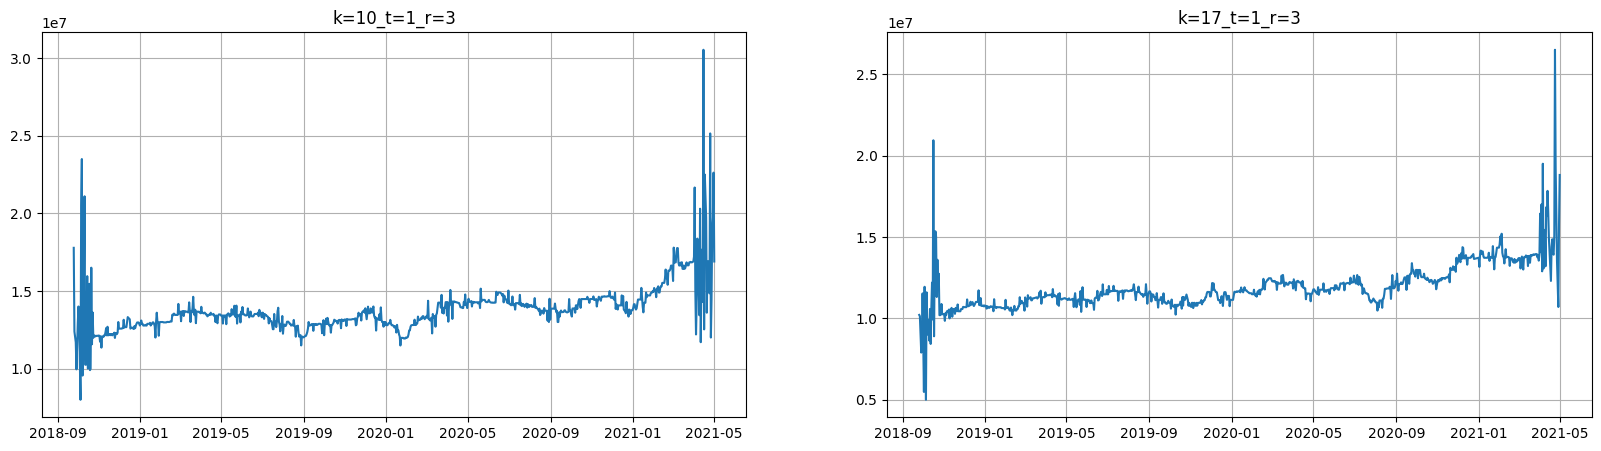

In [41]:
ts.plot(segments=("k=17_t=1_r=3", "k=10_t=1_r=3"))

In [48]:
# train_ts, test_ts = ts.train_test_split(
#     train_start="2018-09-25",
#     train_end="2020-11-01",
#     test_start="2020-11-01",
#     test_end="2021-05-01",
# )
train_ts, test_ts = ts.train_test_split(
    train_start="2018-10-25",
    train_end="2020-07-31",
    test_start="2020-08-01",
    test_end="2021-01-27",
)

In [171]:
_test_end = {1 : "2020-08-30", 2 : "2020-09-29", 3 : "2020-10-29", 4 : "2020-11-28", 5 : "2020-12-28", 6 : "2021-01-27"}

### Catboost

In [49]:
from etna.transforms import LagTransform, LogTransform, LinearTrendTransform , MinMaxScalerTransform
HORIZON = 180
MAX_LAG = HORIZON + 400
lags = LagTransform(in_column="target", lags=list(range(HORIZON,MAX_LAG)))
# log = LogTransform(in_column="target")
# trend = LinearTrendTransform(in_column="target")
# scaler = MinMaxScalerTransform(in_column="target")
transforms = [lags]
train_ts.fit_transform(transforms)

In [205]:
train_ts

segment                                                             k=0_t=11_r=1  \
feature    LagTransform(in_column = 'target', lags = [120], out_column = None, )   
timestamp                                                                          
2018-10-25                                                NaN                      
2018-10-26                                                NaN                      
2018-10-27                                                NaN                      
2018-10-28                                                NaN                      
2018-10-29                                                NaN                      
...                                                       ...                      
2020-07-27                                       6.531621e+06                      
2020-07-28                                       6.531621e+06                      
2020-07-29                                       6.531621e+06                      
2020-07-30                                       6.531621e+06                      
2020-07-31                                       6.531621e+06                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [121], out_column = None, )   
timestamp                                                                          
2018-10-25                                                NaN                      
2018-10-26                                                NaN                      
2018-10-27                                                NaN                      
2018-10-28                                                NaN                      
2018-10-29                                                NaN                      
...                                                       ...                      
2020-07-27                                       6.531621e+06                      
2020-07-28                                       6.531621e+06                      
2020-07-29                                       6.531621e+06                      
2020-07-30                                       6.531621e+06                      
2020-07-31                                       6.531621e+06                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [122], out_column = None, )   
timestamp                                                                          
2018-10-25                                                NaN                      
2018-10-26                                                NaN                      
2018-10-27                                                NaN                      
2018-10-28                                                NaN                      
2018-10-29                                                NaN                      
...                                                       ...                      
2020-07-27                                       6.531621e+06                      
2020-07-28                                       6.531621e+06                      
2020-07-29                                       6.531621e+06                      
2020-07-30                                       6.531621e+06                      
2020-07-31                                       6.531621e+06                      

segment                                                                           \
feature    LagTransform(in_column = 'target', lags = [123], out_column = None, )   
timestamp                                                                          
2018-10-25                                                NaN                      
2018-10-26                                                NaN                      
2018-10-27                                       

In [50]:
from etna.models import CatBoostMultiSegmentModel
from etna.models import CatBoostPerSegmentModel
HORIZON = 180
model =  CatBoostMultiSegmentModel()
model.fit(train_ts) #обучила модель, получила веса
future_ts = train_ts.make_future(future_steps=HORIZON, transforms=transforms) #трансформирую тестовую выборку в нужное представление (операции, аналогичные трансформу)
forecast_ts = model.forecast(future_ts) #предсказала
forecast_ts.inverse_transform(transforms) #вернула в исходный вид

In [51]:
forecast_ts.size

<bound method TSDataset.size of segment                                                             k=0_t=11_r=1  \
feature    LagTransform(in_column = 'target', lags = [180], out_column = None, )   
timestamp                                                                          
2020-08-01                                       7.310765e+06                      
2020-08-02                                       7.310765e+06                      
2020-08-03                                       7.395000e+06                      
2020-08-04                                       7.310765e+06                      
2020-08-05                                       7.310765e+06                      
...                                                       ...                      
2021-01-23                                       8.500452e+06                      
2021-01-24                                       8.535963e+06                      
2021-01-25                                  

In [218]:
test_ts.size

<bound method TSDataset.size of segment     k=0_t=11_r=1  k=0_t=11_r=2  k=0_t=11_r=3  k=0_t=11_r=4  \
feature           target        target        target        target   
timestamp                                                            
2020-08-01  8.622250e+06  1.002810e+07  1.329454e+07  1.816244e+07   
2020-08-02  8.622250e+06  1.002810e+07  1.329454e+07  1.819173e+07   
2020-08-03  8.636111e+06  1.002810e+07  1.331747e+07  1.822101e+07   
2020-08-04  8.643528e+06  1.007940e+07  1.332537e+07  1.825029e+07   
2020-08-05  8.643528e+06  1.008406e+07  1.335376e+07  1.827958e+07   
...                  ...           ...           ...           ...   
2020-12-24  8.984996e+06  1.150401e+07  1.474093e+07  2.194000e+07   
2020-12-25  9.000303e+06  1.153002e+07  1.474093e+07  2.194000e+07   
2020-12-26  9.011321e+06  1.156857e+07  1.474093e+07  2.194000e+07   
2020-12-27  9.011321e+06  1.160180e+07  1.474093e+07  2.194000e+07   
2020-12-28  9.011321e+06  1.163401e+07  1.481557e+07  2.19

In [52]:
from etna.metrics import SMAPE
from etna.metrics import MAPE
from etna.metrics import MAE

mape = MAPE()
mape_all = mape(y_true=test_ts, y_pred=forecast_ts)
smape = SMAPE()
smape_all = smape(y_true=test_ts, y_pred=forecast_ts)
mae = MAE()
mae_all = mae(y_true=test_ts, y_pred=forecast_ts)


In [53]:
sum_mape = 0
for _ , value in mape_all.items():
    sum_mape += value
mean_mape = sum_mape / len(mape_all)
print(mean_mape)

8.461207319483169


In [54]:
sum_smape = 0
for _ , value in smape_all.items():
    sum_smape += value
smean_mape = sum_smape / len(smape_all)
print(smean_mape)

8.593643059386645


In [55]:
sum_mae = 0
for _ , value in mae_all.items():
    sum_mae += value
sum_mae = sum_mae / len(mae_all)
print(sum_mae)

1340026.9809817793


In [56]:
model.save('../models/model_forcasting_days_clear.sav')